# Generative Adversarial Networks for Data Augmentation | Part 1
- In this kernel, we will be using a **DC-GAN** for class-based conditional augmentation, and will be creating GAN augmented datasets, which we will be using in the second part of this kernel to perform classification.

### References
- [Torch Dataset and Dataloader – Early Loading of Data](https://www.analyticsvidhya.com/blog/2021/09/torch-dataset-and-dataloader-early-loading-of-data/)
- [torch dataloader for large csv file - incremental loading]()

# 1. Importing the Packages & Boilerplate Code

In [1]:
import os
import sys
import csv
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from shutil import copyfile
from tabulate import tabulate
from numba import cuda
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

print(torch.__version__)

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e545c2780ea5ef091ceaf8103c4e8727540b7d1377b13e03e20b7104980c447d
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
1.9.1


In [2]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

In [4]:
# Checking if PyTorch can use GPU
if torch.cuda.is_available():  dev = "cuda:0" 
else:  dev = "cpu"  
    
device = torch.device(dev)  
print(dev, device)

cuda:0 cuda:0


In [5]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

# 2. Importing the Train/Test Sets

In [6]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")
df_train = np.array(df_train)
y_train = np.array(y_train)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))

# Basic Pre-processing
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = np.array(df_train[perm, : , : , : ])
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = df_train / 255
df_train = torch.from_numpy(df_train).float().to(device = device)
y_train = torch.from_numpy(np.ravel(y_train)).long().to(device = device)
y_train_oh = F.one_hot(y_train)

# 3. Parameters and Dataloaders
## 3.1. Defining some important parameters

In [7]:
cifar_shape = (3, 32, 32)
n_classes = 10
n_epochs = 1000 # Need to Increase
z_dim = 64
display_step = 500
batch_size = 32
lr = 0.0002

# Generator Input Dimension
generator_input_dim = z_dim + n_classes

In [8]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

train_dataset = MyDataset(df_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)

# 4. Creating & Training the GAN Model
## 4.1. Generator Class

In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=2, final_layer=True),
        ) 
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
        
    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)
    
def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x, y):
    return torch.cat([x, y], 1)

def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels, n_classes)

## 4.2. Discriminator Class

In [10]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, stride=1),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## 4.3. Training the GAN Model

In [11]:
def train_generator():
    gen = Generator(generator_input_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    discriminator_input_dim = cifar_shape[0] + n_classes
    disc = Discriminator(discriminator_input_dim).to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

    criterion = nn.BCEWithLogitsLoss()
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for epoch in range(n_epochs):
        # Dataloader returns the batches and the labels
        for real, labels in train_dataloader:
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)

            # Convert the labels from the dataloader into one-hot versions of those labels
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar_shape[1], cifar_shape[2])

            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
            # Combine the vectors of the noise and the one-hot labels for the generator
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)
            # Combine the vectors of the images and the one-hot labels for the discriminator
            fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            disc_real_pred = disc(real_image_and_labels)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()

            # Pass the discriminator the combination of the fake images and the one-hot labels
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(fake)
                show_tensor_images(real)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1
    
    # Saving the Generator and Discriminator Models
    torch.save(gen.state_dict(), "./gen.pt")
    torch.save(disc.state_dict(), "./disc.pt")
            
# Training the Generator
# train_generator()

## 4.4. Visualizing the GAN's Results

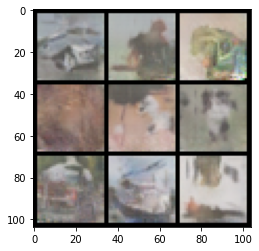

In [12]:
# Loading the Generator
# gen_path = "./gen.pt"
gen_path = "../input/dcai-rw/gen.pt"
gen = Generator(generator_input_dim).to(device)
gen.load_state_dict(torch.load(gen_path))

labels = torch.Tensor(np.random.choice(10, 9))
labels = labels.to(device).to(torch.int64)
one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()
fake_noise = get_noise(len(labels), z_dim, device=device)
noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
fake = gen(noise_and_labels).detach()

show_tensor_images(fake, num_images = 9, nrow = 3)

# 5. Using the trained GAN to generate Datasets
## 5.1. Image Augmentation on 25% of the Training Dataset

In [13]:
# Creating the Dataloader
batch_size = 32
gen_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

df_25per_aug = []
y_25per_aug = []
cur_examples = 0

with torch.no_grad():
    for _, labels in train_dataloader:
        if cur_examples < int(0.25 * len(df_train)):
            labels = labels.to(device)
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()
            cur_batch_size = len(labels)
            cur_examples += cur_batch_size

            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels).detach()
            fake = np.reshape(fake.cpu(), (batch_size, -1))
            fake = torch.split(fake, 1, dim=0)

            df_25per_aug.append(fake)
            y_25per_aug.append(labels)
print(cur_examples, len(df_25per_aug), len(y_25per_aug))

new_df, new_y = [], []
for tup in df_25per_aug:
    for ele in tup:
        new_df.append(torch.squeeze(ele).numpy())
for tens in y_25per_aug:
    new_y.extend(list(tens.cpu().numpy()))

df_25per_aug = pd.DataFrame(new_df)
y_25per_aug = pd.Series(new_y)
print(df_25per_aug.shape, y_25per_aug.shape)

# Saving the augmented images to a CSV file
df_25per_aug.to_csv("df_25per_aug.csv", index = False)
y_25per_aug.to_csv("y_25per_aug.csv", index = False)

10016 313 313
(10016, 3072) (10016,)


## 5.2. Image Augmentation for Class Balancing
### 5.2.1. Finding out the Class Imbalance

In [14]:
y_train_reshape = np.reshape(y_train.cpu(), (-1))
num_examples = np.zeros((10,))

for i in y_train_reshape:
    num_examples[i] += 1

# Number of examples from each class
num_exa = num_examples.astype('int32')

# Finding out the maximum number of examples for any class
max_exa = max(num_exa)

# Number of examples that needs to be added to each of the classes
aug_exa = [max_exa - num_exa[i] for i in range(10)]

# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
for i in range(10):
    classes_ind.append([])

for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)

print(num_exa)
print(aug_exa, sum(aug_exa))
print(len(classes_ind), len(classes_ind[0]))

# Creating a list for the labels corresponding to which augmentation needs to be done
# These are randomly chosen from each class
y_clsbal_aug = []

for i in range(10):
    indices = random.choices(classes_ind[i], k = aug_exa[i])
    y_clsbal_aug.extend([i]*aug_exa[i])
print(len(y_clsbal_aug))

[4109 3839 4022 4116 4312 3952 4290 3552 3436 4378]
[269, 539, 356, 262, 66, 426, 88, 826, 942, 0] 3774
10 4109
3774


### 5.2.2. Augmenting based on the Class Imbalance

In [15]:
batch_size = 37
df_clsbal_aug = []
cur_examples = 0

while cur_examples < len(y_clsbal_aug):
    labels = y_clsbal_aug[cur_examples : cur_examples + batch_size]
    labels = torch.Tensor(labels).to(device).long()
    one_hot_labels = get_one_hot_labels(labels, n_classes).float()
    cur_examples += batch_size

    fake_noise = get_noise(batch_size, z_dim, device=device)
    noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels).detach()
    fake = np.reshape(fake.cpu(), (batch_size, -1))
    fake = torch.split(fake, 1, dim=0)

    df_clsbal_aug.append(fake)
print(cur_examples, len(df_clsbal_aug), len(y_clsbal_aug))

new_df = []
for tup in df_clsbal_aug:
    for ele in tup:
        new_df.append(torch.squeeze(ele).numpy())

df_clsbal_aug = pd.DataFrame(new_df)
y_clsbal_aug = pd.Series(y_clsbal_aug)
print(df_clsbal_aug.shape, y_clsbal_aug.shape)

# Saving the augmented images to a CSV file
df_clsbal_aug.to_csv("df_clsbal_aug.csv", index = False)
y_clsbal_aug.to_csv("y_clsbal_aug.csv", index = False)

3774 102 3774
(3774, 3072) (3774,)


## 5.3. Image Augmentation based on class-wise performance
### 5.3.1. Finding out the class-wise performance of the baseline model
- These results have been borrowed from the kernel of [Traditional Augmentation](https://www.kaggle.com/code/elemento/rw-tradaug/notebook).

In [16]:
# Creating a list of lists for storing the indices of data-points in the training dataset, class-wise
classes_ind = []
y_train_reshape = np.reshape(y_train.cpu(), (-1))
for i in range(10):
    classes_ind.append([])
for ind, clss in enumerate(y_train_reshape):
    classes_ind[clss].append(ind)

# As for the under-performing classes, we will simply be choosing those classes 
# having accuracy less than 80%
und_cls = [2, 3, 4, 5, 7]

### 5.3.2. Augmenting based on the class-wise performance

In [17]:
# Creating an empty list
df_clsper_aug, y_clsper_aug = [], []

# 50% Sampling
for clas in und_cls:
    for ind in tqdm(classes_ind[clas]):
        if np.random.uniform() <= 0.5:
            y_clsper_aug.append(y_train[ind].item())
print(len(y_clsper_aug))

batch_size = 32
df_clsper_aug = []
cur_examples = 0

while cur_examples + batch_size < len(y_clsper_aug):
    labels = y_clsper_aug[cur_examples : cur_examples + batch_size]
    labels = torch.Tensor(labels).to(device).long()
    one_hot_labels = get_one_hot_labels(labels, n_classes).float()
    cur_examples += batch_size

    fake_noise = get_noise(batch_size, z_dim, device=device)
    noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels).detach()
    fake = np.reshape(fake.cpu(), (batch_size, -1))
    fake = torch.split(fake, 1, dim=0)

    df_clsper_aug.append(fake)
print(cur_examples, len(df_clsper_aug), len(y_clsper_aug))

new_df = []
for tup in df_clsper_aug:
    for ele in tup:
        new_df.append(torch.squeeze(ele).numpy())

df_clsper_aug = pd.DataFrame(new_df)
y_clsper_aug = pd.Series(y_clsper_aug[:cur_examples])
print(df_clsper_aug.shape, y_clsper_aug.shape)

# Saving the augmented images to a CSV file
df_clsper_aug.to_csv("df_clsper_aug.csv", index = False)
y_clsper_aug.to_csv("y_clsper_aug.csv", index = False)

100%|██████████| 3552/3552 [00:00<00:00, 77776.51it/s]


10050
10048 314 10050
(10048, 3072) (10048,)
